In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp

import networkx as nx

import torch
dtype = torch.float
device = torch.device("cpu")

from utils.utils import *

In [2]:
def laplacian(A):
    '''
    Calculates the Laplacian matrix of a graph based on its adjacency matrix A.

    Args:
    - A: Adjacency matrix of the graph

    Returns:
    - L: Laplacian matrix of the graph
    '''
    # Calculate the row sums of the adjacency matrix
    K = torch.sum(A, dim=1)
    
    # Construct the Laplacian matrix and return it
    K = torch.diag_embed(K)
    return torch.matmul( torch.inverse(K), K - A )
    #return K - A

def statistical_propagator(L, tau):
    '''
    Computes the statistical propagator matrix using the matrix exponential of the Laplacian and a given time step tau.

    Args:
    - L: Laplacian matrix of the graph
    - tau: Time step

    Returns:
    - U: Statistical propagator matrix
    '''
    return torch.matrix_exp(-tau * L)

def density_matrix(L, tau):
    '''
    Computes the density matrix by normalizing the statistical propagator matrix using its trace.

    Args:
    - L: Laplacian matrix of the graph
    - tau: Time step

    Returns:
    - Density matrix of the system
    '''
    # Compute the statistical propagator matrix
    U = statistical_propagator(L, tau)
    
    # Normalize the matrix by dividing it by its trace and return
    return U / torch.trace(U)

def entropy(L, tau):
    '''
    Computes the von Neumann entropy using the statistical propagator and given time step tau.
    S(rho) = -Tr(rho log(rho)) = -Tr(U/Z log(U/Z))
           = tau / Z * Tr(U@L) + log(Z)

    Args:
    - L: Laplacian matrix of the graph
    - tau: Time step

    Returns:
    - Von Neumann entropy of the system
    '''
    # Compute the statistical propagator matrix
    U = statistical_propagator(L, tau)
    
    # Calculate the trace of the statistical propagator matrix
    Z = torch.trace(U)
    
    # Compute and return the von Neumann entropy formula
    return torch.log(Z) + tau / Z * torch.trace(torch.matmul(U, L))

def efficiency(L, tau):
    '''
    Computes the efficiency of a system in terms of its density matrix.
    eta = 1 + Q / W = ( S - log(Z) ) / ( log(N) - log(Z) )
        = tau / Z * Tr(U@L) / ( log(N) - log(Z) )

    Args:
    - L: Laplacian matrix of the graph
    - tau: Time step

    Returns:
    - Efficiency of the system
    '''
    # Compute the statistical propagator matrix
    U = statistical_propagator(L, tau)
    
    # Calculate the trace of the statistical propagator matrix and the size of the system
    Z = torch.trace(U)
    N = L.size(dim=1)
    
    # Compute and return the efficiency of the system
    return tau / Z * torch.trace(torch.matmul(U, L)) / (np.log(N) - torch.log(Z))

In [3]:
def compute_dimension_tau(Zs, taus):
    D = np.log(Zs)
    D = (D[1:]-D[:-1]) / (np.log(taus)[1:]-np.log(taus)[:-1])
    return -2*D

def compute_spectral_dimension(Zs, taus, tmin, tmax):
    idx = np.where((taus>tmin)*(taus<tmax))[0]

    return -2*np.polyfit(np.log(taus)[idx], np.log(Zs)[idx], deg=1)[0]

# Show example

In [6]:
mat = nx.grid_2d_graph(50, 50)
mat = nx.to_numpy_array(mat)

mat = torch.tensor(mat)

In [7]:
taus = np.logspace(-3,4,100)

L = laplacian(mat)
tmp_eff = np.array( [torch.trace(statistical_propagator(L,tau)).detach().numpy() for tau in taus] )

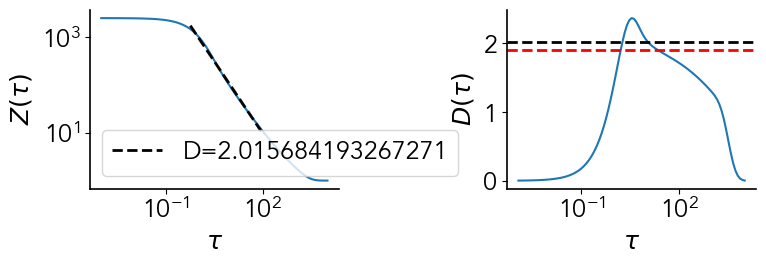

In [9]:
plt.figure(figsize=(8,3))

tmin = 5e-1
tmax = 1e2
idx = np.where((taus>tmin)*(taus<tmax))[0]

m, q = np.polyfit(np.log(taus)[idx], np.log(tmp_eff)[idx], deg=1)
dfit = -2*m

plt.subplot(1,2,1)
plt.plot(taus, tmp_eff )
plt.plot(taus[idx],np.exp(np.log(taus[idx])*m+q), ls='--', c='k', lw=2, label=f'D={dfit}' )
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Z(\tau)$')
plt.legend()

D = np.log(tmp_eff)
D = (D[1:]-D[:-1]) / (np.log(taus)[1:]-np.log(taus)[:-1])
D = -2*D

plt.subplot(1,2,2)
plt.plot(taus[1:], D )
plt.axhline(dfit, ls='--', lw=2, c='k', label=f'D={np.round(dfit,2)}')
plt.axhline(D[idx].mean(), ls='--', lw=2, c='r', label=f'Dmean={D[idx].mean()}')
#plt.axhline(D[idx].mean(), ls='--', lw=2, c='k')
plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$D(\tau)$')

plt.tight_layout()
plt.show()

In [43]:
taus = np.logspace(-.8,2.2,100)
tmin = 2e0
tmax = 1e1
ses = 1

effs_control = []
dims_control = []

for parc in parcellations:
    ### Create data-loader
    control = data_loader(which='control', ses=ses, parc=parc, include_subctx=False, thr='mask')
    #stroke = data_loader(which='stroke', ses=ses, parc=parc, include_subctx=False, thr='mask')
    
    ### Get matrix
    mat = control.load_matrix(0)
    mat /= mat.max()
    mat = torch.tensor(mat)
    L = laplacian(mat)
    
    ### Compute partition function
    Zs = np.array( [torch.trace(statistical_propagator(L,tau)).detach().numpy() for tau in taus] )
    
    ### Compute dimension
    dim = compute_spectral_dimension(Zs, taus, tmin, tmax)
    
    ### Store results
    effs_control.append(Zs)
    dims_control.append(dims_control)

######## control - ses 01 - parc 100 - total 29 - thr mask - subctx False ########
- Loading sub-040
######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
- Loading sub-040
######## control - ses 01 - parc 500 - total 29 - thr mask - subctx False ########
- Loading sub-040


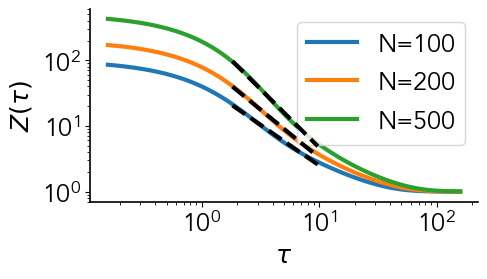

In [49]:
tmin = 1.8e0
tmax = 1e1
idx = np.where((taus>tmin)*(taus<tmax))[0]

plt.figure(figsize=(5,2.5))

for idx_parc, Zs in enumerate(effs_control):
    m, q = np.polyfit(np.log(taus)[idx], np.log(Zs)[idx], deg=1)
    dfit = -2*m
    plt.plot(taus[idx],np.exp(np.log(taus[idx])*m+q), ls='--', c='k', lw=3, zorder=10) #, label=f'D={np.round(dfit,2)}' )
    
    label = f'N={parcellations[idx_parc]}'
    plt.plot(taus, Zs, label=label, lw=3, zorder=1)
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Z(\tau)$')
plt.ylim([0.7,6e2])
plt.legend()
plt.savefig('figures/'+'fig_suppl_partition_function.png', dpi=200, bbox_inches='tight')
plt.show()

# Compute for all dataset

In [11]:
taus = np.logspace(-1.,2.5,100)
tmin = 2e0
tmax = 1e1

folder = 'results/spectral_dimension/'
ses = 1

effs_control = []
dims_control = []

tmp_dicts = [dict_control, dict_stroke]

for tmp_dict in tmp_dicts:
    which = tmp_dict['name']
    
    for parc in tmp_dict['parcs']:
        # Load dataset
        data = data_loader(which=which, ses=ses, parc=parc, thr='mask', include_subctx=False)
    
        for idx, mat in enumerate(data):
            # Check if connected - otherwise it has returned None
            if mat is None: continue
                
            ### Load connectome
            mat /= mat.max()
            mat = torch.tensor(mat)
            L = laplacian(mat)
    
            ### Compute partition function    
            Zs = np.array( [torch.trace(statistical_propagator(L,tau)).detach().numpy() for tau in taus] )
            
            ### Compute dimension
            dim = compute_spectral_dimension(Zs, taus, tmin, tmax)
    
            ### Store results
            np.savetxt(folder+data.full_names[idx], [dim])
            np.savetxt(folder+'partition_'+data.full_names[idx], Zs)

######## control - ses 01 - parc 100 - total 29 - thr mask - subctx False ########
- Loading sub-040
- Loading sub-041
- Loading sub-042
- Loading sub-043
- Loading sub-044
- Loading sub-045
- Loading sub-046
- Loading sub-047
- Loading sub-048
- Loading sub-049
- Loading sub-050
- Loading sub-051
- Loading sub-052
- Loading sub-055
- Loading sub-057
- Loading sub-059
- Loading sub-060
- Loading sub-061
- Loading sub-062
- Loading sub-063
- Loading sub-064
- Loading sub-065
- Loading sub-066
- Loading sub-067
- Loading sub-068
- Loading sub-069
- Loading sub-070
- Loading sub-071
- Loading sub-072
######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
- Loading sub-040
- Loading sub-041
- Loading sub-042
- Loading sub-043
- Loading sub-044
- Loading sub-045
- Loading sub-046
- Loading sub-047
- Loading sub-048
- Loading sub-049
- Loading sub-050
- Loading sub-051
- Loading sub-052
- Loading sub-055
- Loading sub-057
- Loading sub-059
- Loading sub-060
- Load